In [20]:
from imports import *

### **Quantum Entanglement**
**Quantum entanglement** links two particles so that measuring one instantly tells us about the other — even if they're far apart. Einstein called this “spooky action at a distance.” In 1964, **Bell’s inequality** was proposed to test if particles follow classical rules. The **CHSH experiment** showed that entangled particles behave in ways classical physics can’t explain. In 1997, scientists used entanglement to achieve **quantum teleportation** — sending a quantum state without moving the particle itself.

Let’s use **Qiskit** to explore the CHSH test and quantum teleportation!

### **CHSH Game**
The CHSH game is a thought experiment based on ideas from quantum physics. It was proposed as a way to test whether the world behaves according to classical rules or quantum mechanics. In 1964, physicist [John Bell](https://en.wikipedia.org/wiki/John_Stewart_Bell) introduced Bell's inequality to show that certain predictions of quantum mechanics can't be explained by any local classical theory. Later, Clauser, Horne, Shimony, and Holt (CHSH) created a practical version of this test — now called the CHSH game. The game involves two players, Alice and Bob, who cannot talk to each other once the game starts. They try to win a challenge given by a Referee by using a strategy they agree on beforehand.

Here’s how the CHSH game works:

1. The Referee randomly picks two input bits: `x` and `y`.
2. `x` is sent to Alice, and `y` is sent to Bob.
3. Without knowing each other's input, Alice and Bob each send back one bit: `a` and `b`.
4. **They win if:** `a XOR b == x AND y`

This means:
- In most cases, when `x` and `y` are not both 1, Alice and Bob should give the same answer.
- If both `x = 1` and `y = 1`, they must give different answers.

Since they can't communicate, they need a strategy that works on average. With only classical logic, the best they can do is win **75%** of the time.


### **Classical Limit**
The classical limit of this game is win_probability $\leq = 75% $. To understand why the classical success rate in the CHSH game is limited to 75%, let’s look at all possible input combinations the Referee might send:
$$(x, y) \in \{(0,0), (0,1), (1,0), (1,1)\}$$
The win condition is:
$$a \oplus b == x \land y$$
This means:
- For (0,0), (0,1), and (1,0), the right side is 0 → Alice and Bob must give the **same** output.
- For (1,1), the right side is 1 → they must give **different** outputs.

Now suppose Alice and Bob agree on a fixed classical strategy, like always outputting 0.  
They will win for the first 3 cases, but lose when (x, y) = (1,1), because:
$$0 \oplus 0 = 0 \neq 1 $$
No matter what fixed classical strategy they use, **only 3 out of 4 cases can be satisfied**. This means:

**The best possible classical success rate is 75%.**

### **Quantum Strategy**
Suppose Alice and Bob share a special quantum resource *before* playing their game — a pair of entangled qubits in the Bell state:

$$
|\psi\rangle = \frac{1}{\sqrt{2}} (|00\rangle + |11\rangle)
$$

Think of this state as two "quantum coins" that are perfectly correlated: even when separated by vast distances, measuring one immediately determines the outcome correlation of the other. While no information is transmitted faster than light, their results exhibit quantum-connected behavior.

Here’s how they use this entangled state to win more often in the CHSH game:

1. **Entangled Resource**  
   Alice holds qubit 0, Bob holds qubit 1 from their shared Bell state.

2. **Input-Dependent Measurement**  
   - **Alice**, upon receiving input `x`, measures her qubit as follows:
     - If `x = 0`: she measures in the standard **Z basis** (angle 0).
     - If `x = 1`: she measures in the **X basis** (angle $\pi/2$).
   - **Bob**, upon receiving input `y`, applies a rotation `Ry(-π/4)` if `y = 0` or `Ry(π/4)` if `y = 1`, then measures in the Z basis.

3. **Outcome**  
   Each player outputs the result of their measurement: `a` for Alice and `b` for Bob. The magic lies in the quantum correlations: with the above angles, their outputs satisfy the winning condition $a \oplus b = x \land y$ with probability higher than the classical limit.

Lets now create a quantum circuit to implement this strategy.

In [13]:
def chsh_game(x,y):
    qc = QuantumCircuit(2, 2, name = f'CHSH_{x}{y}')
    # First, Create the Bell State
    qc.h(0)                    # put in superposition
    qc.cx(0,1)
    qc.barrier()
    # Alice's measurement basis
    if x==1:
        qc.h(0)
    # Bob's measurement basis
    if y==0:
        qc.ry(-np.pi / 4, 1)
    else:
        qc.ry(np.pi / 4, 1)
    qc.barrier()

    qc.measure([0,1],[0,1])
    return qc



### **Creating circuit for all inputs**

Quantum Circuit if x = y = 1


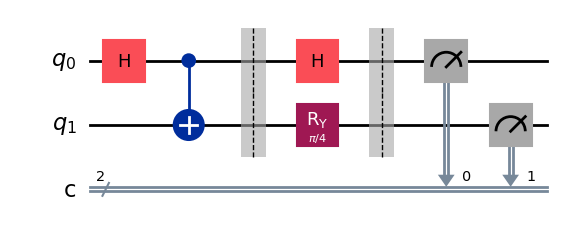

In [14]:
circuits = []
input_vals = []
for x_in in [0,1]:
    for y_in in [0,1]:
        input_vals.append((x_in , y_in))
        circuits.append(chsh_game(x_in, y_in))
print("Quantum Circuit if x = y = 1")
if len(circuits) == 4:
    display(circuits[3].draw('mpl')) # (x,y) = (1,1)
else:
    print("Circuits not generated")

### **Lets now run the game multiple times**


--- Results (Counts) ---
Inputs (x = 0, y = 0):
  Outcomes (ba): {'00': 436, '01': 89, '10': 73, '11': 426}
Inputs (x = 0, y = 1):
  Outcomes (ba): {'00': 453, '01': 67, '10': 69, '11': 435}
Inputs (x = 1, y = 0):
  Outcomes (ba): {'00': 442, '01': 77, '10': 62, '11': 443}
Inputs (x = 1, y = 1):
  Outcomes (ba): {'00': 65, '01': 443, '10': 438, '11': 78}

Plotting results...


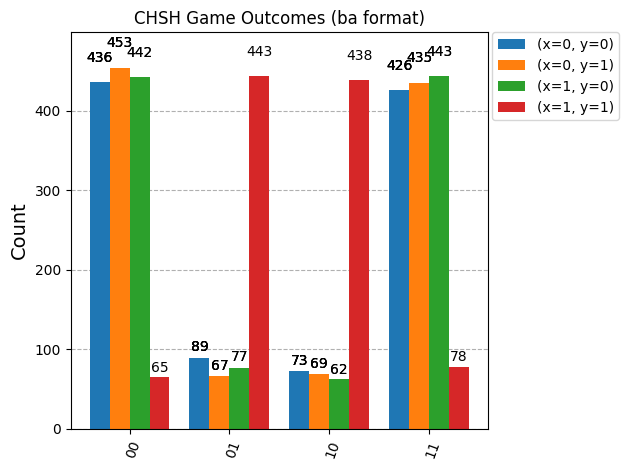

In [15]:
backend = AerSimulator()
num_shots = 1024
pass_manager = generate_preset_pass_manager(backend = backend, optimization_level=3)
compiled_circuit = pass_manager.run(circuits)

sampler_chsh = Sampler(mode = backend)
job = sampler_chsh.run(compiled_circuit, shots = num_shots)
result = job.result()


count_list = [result[i].data.c.get_counts() for i in range(len(circuits))]
print("\n--- Results (Counts) ---")
for i, (x,y) in enumerate(input_vals):
    print(f"Inputs (x = {x}, y = {y}):")
    sorted_counts = dict(sorted(count_list[i].items()))
    print(f"  Outcomes (ba): {sorted_counts}")
print("\nPlotting results...")
display(plot_histogram(count_list,legend=[f'(x={x}, y={y})' for x, y in input_vals],title='CHSH Game Outcomes (ba format)'))

### **Did it beat the classical limit** ?
Lets calculate the win probability 

In [17]:
win_probability = {}
print("----- Calculating the win probability -----")

for i, (x,y) in enumerate(input_vals):
    counts = count_list[i]
    xor_result = x & y
    wins = 0

    for outcome, count in counts.items():
        b = int(outcome[0])
        a = int(outcome[1])

        if (a ^ b) == xor_result:
            wins +=  count

    prob = wins / num_shots if num_shots > 0 else 0
    win_probability[(x,y)] = prob
    print(f"Inputs (x={x}, y={y}): Target (a XOR b) = {xor_result}. Win Probability = {prob:.4f}")
avg_win_prob = sum(win_probability.values()) / 4.0
quantum_result = np.cos(np.pi / 8)**2
classical_limit = 0.75
print("\n--- Overall Performance ---")
print(f"Experimental Average Win Probability: {avg_win_prob:.4f}")
print(f"Theoretical Quantum Win Probability: {quantum_result:.4f}")
print(f"Classical Limit Win Probability:     {classical_limit:.4f}")

if avg_win_prob > classical_limit + 0.01: # Allow for small simulation variance
    print(f"\nSuccess! Our result ({avg_win_prob:.4f}) clearly beats the classical 75% limit!")
    print(f"It's likely close to the theoretical quantum prediction of {quantum_result:.4f}.")
elif avg_win_prob > classical_limit - 0.02 : # Could be noise or minor error
     print(f"\nClose, but no cigar? Your result ({avg_win_prob:.4f}) is around the classical limit ({classical_limit:.4f}).")
     print("Check your solutions for Exercises 1-4 carefully, especially the win counting logic in Ex 4.")
else:
    print(f"\nHmm, the result ({avg_win_prob:.4f}) is unexpectedly low, even below the classical limit.")
    print("There might be an error in Exercises 1-4. Please review your circuit and analysis code.")


----- Calculating the win probability -----
Inputs (x=0, y=0): Target (a XOR b) = 0. Win Probability = 0.8418
Inputs (x=0, y=1): Target (a XOR b) = 0. Win Probability = 0.8672
Inputs (x=1, y=0): Target (a XOR b) = 0. Win Probability = 0.8643
Inputs (x=1, y=1): Target (a XOR b) = 1. Win Probability = 0.8604

--- Overall Performance ---
Experimental Average Win Probability: 0.8584
Theoretical Quantum Win Probability: 0.8536
Classical Limit Win Probability:     0.7500

Success! Our result (0.8584) clearly beats the classical 75% limit!
It's likely close to the theoretical quantum prediction of 0.8536.


The simulation results show that when Alice and Bob use shared entangled qubits along with carefully chosen measurements, they achieve a win probability close to **85.84%**—well above the classical limit of 75%. This clearly demonstrates the power of quantum entanglement in enabling stronger-than-classical correlations. Far from being a mathematical curiosity, this effect reflects the true behavior of the physical world at the quantum level. Entanglement introduces correlations that cannot be explained by any classical mechanism. While these correlations do not allow faster-than-light communication, they defy classical expectations and form the foundation of many emerging quantum technologies.

This result from the CHSH game reveals something profound: **quantum mechanics allows for nonlocal correlations** that challenge our classical intuition about how information and causality work in the universe. These quantum correlations are not only of theoretical interest—they have real-world applications, such as in quantum cryptography, device-independent security, quantum teleportation, and tests of quantum hardware fidelity.